In [2]:
cd ..

/home/araxal/coursework


In [3]:
from utils.instrument_recognition import feature_preparator
from models.instrument_recognition.LSTMModel import LSTMModel
from models.instrument_recognition.TransformerModel import TransformerModel
import numpy as np
import torch
from utils.instrument_recognition import executor
from utils.instrument_recognition import plot_metrics
from utils.instrument_recognition import evaluate
from torch import nn
from utils.instrument_recognition import plot_confusion_matrix
from sklearn.metrics import classification_report
from utils.instrument_recognition import calculate_accuracy
from utils.instrument_recognition import squeeze_answer_matrix, get_exact_match_ratio, get_accuracy
from matplotlib import pyplot as plt
import seaborn as sns
import pandas as pd
from utils.instrument_recognition.evaluate_multilabel import evaluate_multilabel

In [4]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [5]:
BATCH_SIZE = 8
DEVICE = torch.device('cuda')

In [6]:
dataloaders, idx_to_instrument, instrument_to_idx, shapes = feature_preparator(BATCH_SIZE)

In [7]:
train, val, test = dataloaders['accordion']

In [8]:
z = next(iter(train))
x = next(iter(val))
c = next(iter(test))

print(z[0].shape, z[1].shape, z[2].shape)
print(x[0].shape, x[1].shape, x[2].shape)
print(c[0].shape, c[1].shape, c[2].shape)
print(shapes)

torch.Size([8, 10, 128]) torch.Size([8]) torch.Size([8])
torch.Size([8, 10, 128]) torch.Size([8]) torch.Size([8])
torch.Size([8, 10, 128]) torch.Size([8]) torch.Size([8])
(14915, 2034, 3051)


 21%|██        | 21/100 [00:15<00:57,  1.37it/s]

Early stop!


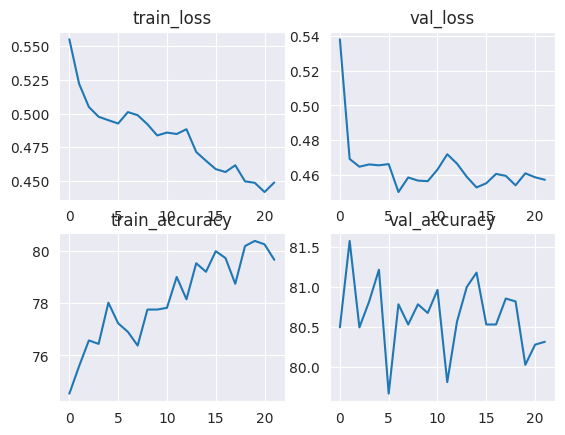

In [40]:
lstm_model = LSTMModel(128).to(DEVICE)
train_progress, val_progress = executor(
    DEVICE,
    lstm_model,
    train_dataloader = train,
    val_dataloader=val,
    epochs=100,
    learning_rate=0.0001,
    weight_decay=0.01,
    evaluate_per_iteration=15,
    early_stop_after=(15,  0.001)
)

plot_metrics(train_progress, val_progress, metrics = ['loss', 'accuracy'])

              precision    recall  f1-score   support

       False       0.81      0.92      0.86       226
        True       0.54      0.31      0.40        70

    accuracy                           0.77       296
   macro avg       0.67      0.62      0.63       296
weighted avg       0.75      0.77      0.75       296



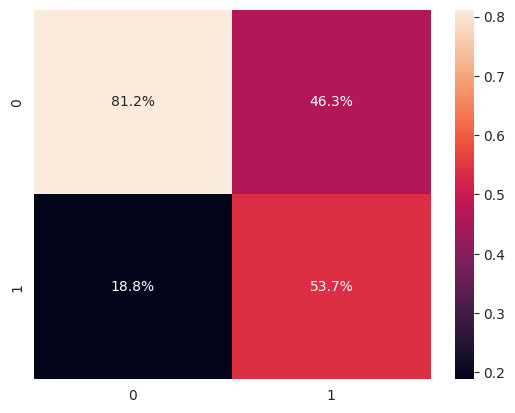

In [41]:
test_loss, test_accuracy, (test_pred, test_true) = evaluate(DEVICE, lstm_model, test, criterion=nn.BCEWithLogitsLoss(), return_pred=True)

plot_confusion_matrix(test_true, test_pred)

 31%|███       | 31/100 [00:51<01:55,  1.68s/it]

Early stop!


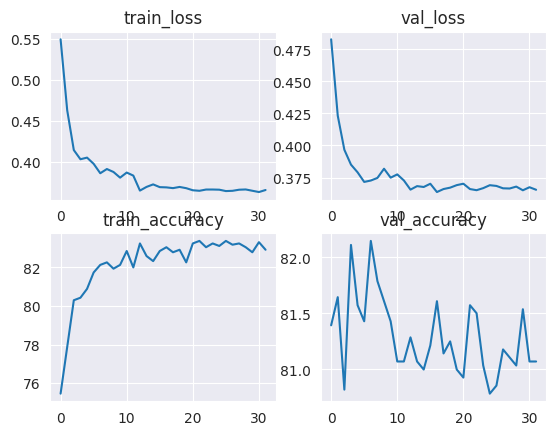

In [9]:
transformer_model = TransformerModel(input_dim=128,
                              num_layers=4,
                              output_dim=1,
                              num_heads=8,
                              dropout=0.1,
                              hidden_dim=128
                              ).to(DEVICE)

train_progress, val_progress = executor(
    DEVICE,
    transformer_model,
    train_dataloader = train,
    val_dataloader=val,
    epochs=100,
    learning_rate=0.0001,
    weight_decay=0.01,
    evaluate_per_iteration=15,
    early_stop_after=(15,  0.001)
)

plot_metrics(train_progress, val_progress, metrics = ['loss', 'accuracy'])

              precision    recall  f1-score   support

       False       0.85      0.95      0.90       226
        True       0.74      0.46      0.57        70

    accuracy                           0.83       296
   macro avg       0.80      0.70      0.73       296
weighted avg       0.82      0.83      0.82       296



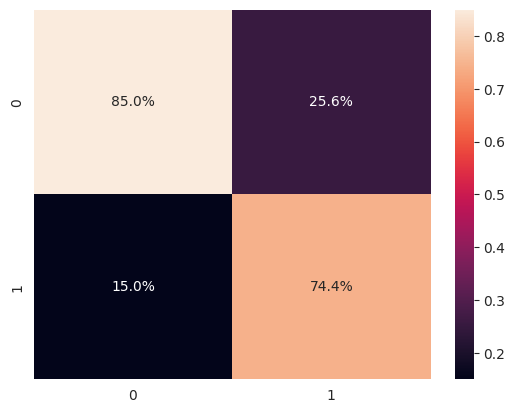

In [11]:
test_loss, test_accuracy, (test_pred, test_true) = evaluate(DEVICE, transformer_model, test, criterion=nn.BCEWithLogitsLoss(), return_pred=True)

plot_confusion_matrix(test_true, test_pred)

In [9]:
resulting_pred, resulting_true = [], []
models = {}

for instrument in idx_to_instrument.values():
    model = LSTMModel(128).to(DEVICE)
    train, val, test = dataloaders[instrument]
    train_progress, val_progress = executor(
        DEVICE,
        model,
        train_dataloader=train,
        val_dataloader=val,
        epochs=100,
        learning_rate=0.0001,
        weight_decay=0.01,
        evaluate_per_iteration=20,
        early_stop_after=(15,  0.001)
    )
    test_loss, test_accuracy, (test_pred, test_true) = evaluate(
        DEVICE,
        model,
        test,
        criterion=nn.BCEWithLogitsLoss(),
        return_pred=True
    )

    models[instrument] = model

    resulting_pred.append(test_pred)
    resulting_true.append(test_true)

    # Строим classification_report для тренировочного и тестового датасета
    print('-' * 52)
    print(instrument)

    print('\tTEST')
    print(classification_report(test_true.cpu(), test_pred.cpu(), zero_division=0))


 27%|██▋       | 27/100 [00:14<00:39,  1.83it/s]


Early stop!
----------------------------------------------------
accordion
	TEST
              precision    recall  f1-score   support

       False       0.81      0.96      0.88       226
        True       0.67      0.29      0.40        70

    accuracy                           0.80       296
   macro avg       0.74      0.62      0.64       296
weighted avg       0.78      0.80      0.76       296



 28%|██▊       | 28/100 [00:16<00:42,  1.71it/s]


Early stop!
----------------------------------------------------
banjo
	TEST
              precision    recall  f1-score   support

       False       0.82      0.81      0.81       187
        True       0.59      0.61      0.60        85

    accuracy                           0.75       272
   macro avg       0.71      0.71      0.71       272
weighted avg       0.75      0.75      0.75       272



 39%|███▉      | 39/100 [00:17<00:26,  2.27it/s]


Early stop!
----------------------------------------------------
bass
	TEST
              precision    recall  f1-score   support

       False       0.83      0.94      0.88       220
        True       0.58      0.32      0.41        60

    accuracy                           0.80       280
   macro avg       0.70      0.63      0.65       280
weighted avg       0.78      0.80      0.78       280



 43%|████▎     | 43/100 [00:19<00:25,  2.22it/s]


Early stop!
----------------------------------------------------
cello
	TEST
              precision    recall  f1-score   support

       False       0.67      0.76      0.71       149
        True       0.74      0.65      0.69       155

    accuracy                           0.70       304
   macro avg       0.70      0.70      0.70       304
weighted avg       0.70      0.70      0.70       304



 20%|██        | 20/100 [00:11<00:45,  1.77it/s]


Early stop!
----------------------------------------------------
clarinet
	TEST
              precision    recall  f1-score   support

       False       0.79      1.00      0.88       306
        True       0.75      0.03      0.07        86

    accuracy                           0.79       392
   macro avg       0.77      0.52      0.47       392
weighted avg       0.78      0.79      0.70       392



 52%|█████▏    | 52/100 [00:19<00:18,  2.61it/s]


Early stop!
----------------------------------------------------
cymbals
	TEST
              precision    recall  f1-score   support

       False       0.87      0.81      0.84        84
        True       0.91      0.94      0.93       172

    accuracy                           0.90       256
   macro avg       0.89      0.88      0.88       256
weighted avg       0.90      0.90      0.90       256



 26%|██▌       | 26/100 [00:11<00:32,  2.26it/s]


Early stop!
----------------------------------------------------
drums
	TEST
              precision    recall  f1-score   support

       False       0.93      0.69      0.79        97
        True       0.83      0.97      0.89       151

    accuracy                           0.86       248
   macro avg       0.88      0.83      0.84       248
weighted avg       0.87      0.86      0.85       248



 30%|███       | 30/100 [00:15<00:35,  2.00it/s]


Early stop!
----------------------------------------------------
flute
	TEST
              precision    recall  f1-score   support

       False       0.71      0.89      0.79       225
        True       0.54      0.25      0.34       111

    accuracy                           0.68       336
   macro avg       0.62      0.57      0.57       336
weighted avg       0.65      0.68      0.64       336



 71%|███████   | 71/100 [00:25<00:10,  2.82it/s]


Early stop!
----------------------------------------------------
guitar
	TEST
              precision    recall  f1-score   support

       False       0.84      0.80      0.82        98
        True       0.88      0.91      0.90       166

    accuracy                           0.87       264
   macro avg       0.86      0.85      0.86       264
weighted avg       0.87      0.87      0.87       264



 45%|████▌     | 45/100 [00:20<00:24,  2.22it/s]


Early stop!
----------------------------------------------------
mallet_percussion
	TEST
              precision    recall  f1-score   support

       False       0.76      0.76      0.76       170
        True       0.66      0.66      0.66       118

    accuracy                           0.72       288
   macro avg       0.71      0.71      0.71       288
weighted avg       0.72      0.72      0.72       288



 38%|███▊      | 38/100 [00:25<00:42,  1.47it/s]


Early stop!
----------------------------------------------------
mandolin
	TEST
              precision    recall  f1-score   support

       False       0.79      0.76      0.78       244
        True       0.54      0.58      0.56       116

    accuracy                           0.70       360
   macro avg       0.66      0.67      0.67       360
weighted avg       0.71      0.70      0.71       360



 30%|███       | 30/100 [00:14<00:32,  2.12it/s]


Early stop!
----------------------------------------------------
organ
	TEST
              precision    recall  f1-score   support

       False       0.74      0.91      0.81       190
        True       0.54      0.24      0.34        82

    accuracy                           0.71       272
   macro avg       0.64      0.58      0.58       272
weighted avg       0.68      0.71      0.67       272



 31%|███       | 31/100 [00:13<00:29,  2.32it/s]


Early stop!
----------------------------------------------------
piano
	TEST
              precision    recall  f1-score   support

       False       0.78      0.81      0.80        70
        True       0.93      0.92      0.92       194

    accuracy                           0.89       264
   macro avg       0.86      0.87      0.86       264
weighted avg       0.89      0.89      0.89       264



 44%|████▍     | 44/100 [00:26<00:33,  1.67it/s]


Early stop!
----------------------------------------------------
saxophone
	TEST
              precision    recall  f1-score   support

       False       0.74      0.74      0.74       192
        True       0.70      0.70      0.70       168

    accuracy                           0.72       360
   macro avg       0.72      0.72      0.72       360
weighted avg       0.72      0.72      0.72       360



 52%|█████▏    | 52/100 [00:19<00:17,  2.70it/s]


Early stop!
----------------------------------------------------
synthesizer
	TEST
              precision    recall  f1-score   support

       False       0.85      0.67      0.75        52
        True       0.90      0.96      0.93       156

    accuracy                           0.89       208
   macro avg       0.88      0.82      0.84       208
weighted avg       0.89      0.89      0.88       208



 40%|████      | 40/100 [00:31<00:47,  1.26it/s]


Early stop!
----------------------------------------------------
trombone
	TEST
              precision    recall  f1-score   support

       False       0.82      0.92      0.87       295
        True       0.61      0.37      0.46        97

    accuracy                           0.79       392
   macro avg       0.71      0.65      0.66       392
weighted avg       0.77      0.79      0.77       392



 42%|████▏     | 42/100 [00:35<00:49,  1.18it/s]


Early stop!
----------------------------------------------------
trumpet
	TEST
              precision    recall  f1-score   support

       False       0.74      0.86      0.79       288
        True       0.62      0.42      0.50       152

    accuracy                           0.71       440
   macro avg       0.68      0.64      0.65       440
weighted avg       0.70      0.71      0.69       440



 23%|██▎       | 23/100 [00:18<01:02,  1.24it/s]


Early stop!
----------------------------------------------------
ukulele
	TEST
              precision    recall  f1-score   support

       False       0.78      0.85      0.82       248
        True       0.60      0.47      0.53       112

    accuracy                           0.74       360
   macro avg       0.69      0.66      0.67       360
weighted avg       0.72      0.74      0.73       360



 19%|█▉        | 19/100 [00:09<00:41,  1.95it/s]


Early stop!
----------------------------------------------------
violin
	TEST
              precision    recall  f1-score   support

       False       0.63      0.65      0.64       122
        True       0.84      0.83      0.84       278

    accuracy                           0.78       400
   macro avg       0.74      0.74      0.74       400
weighted avg       0.78      0.78      0.78       400



 42%|████▏     | 42/100 [00:16<00:22,  2.61it/s]

Early stop!
----------------------------------------------------
voice
	TEST
              precision    recall  f1-score   support

       False       0.84      0.75      0.79        96
        True       0.80      0.88      0.84       112

    accuracy                           0.82       208
   macro avg       0.82      0.81      0.81       208
weighted avg       0.82      0.82      0.82       208



In [10]:
print('INSTRUMENT MACRO ACCURACY:', calculate_accuracy(torch.concat(resulting_pred), torch.concat(resulting_true)))

INSTRUMENT MACRO ACCURACY: 77.177001953125


''

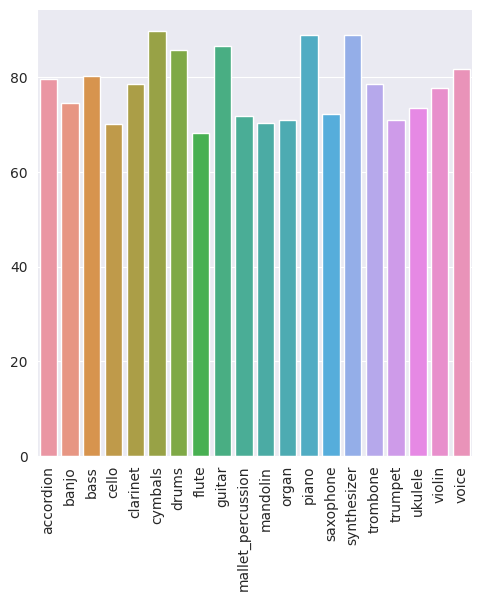

In [11]:
sns.catplot(
    pd.DataFrame(
        columns=idx_to_instrument.values(),
        data=[[calculate_accuracy(*x) for x in zip(resulting_pred, resulting_true)]]
    ),
    kind = 'bar'
)
plt.xticks(rotation=90)
;

In [12]:
test_dataloaders = {
    key: value[2] for key, value in dataloaders.items()
}

true_matrix, pred_matrix = evaluate_multilabel(DEVICE, models, matrix_shape=(shapes[2], len(instrument_to_idx)), dataloaders=test_dataloaders, instrument_to_idx=instrument_to_idx)

print('TEST')
m1 = squeeze_answer_matrix(true_matrix)
m2 = squeeze_answer_matrix(pred_matrix)
print(f'Exact Match Ratio {get_exact_match_ratio(m1, m2)}')
print(f'Accuracy {get_accuracy(m1, m2)}')

TEST
Exact Match Ratio 0.6279908226810882
Accuracy 0.6764448814596307


In [13]:
resulting_pred, resulting_true = [], []
models = {}

for instrument in idx_to_instrument.values():
    model = TransformerModel(input_dim=128,
                             num_layers=4,
                             output_dim=1,
                             num_heads=8,
                             dropout=0.1,
                             hidden_dim=128
                             ).to(DEVICE)
    train, val, test = dataloaders[instrument]
    train_progress, val_progress = executor(
        DEVICE,
        model,
        train_dataloader=train,
        val_dataloader=val,
        epochs=200,
        learning_rate=0.0001,
        weight_decay=0.01,
        evaluate_per_iteration=20,
        early_stop_after=(15,  0.001)
    )
    test_loss, test_accuracy, (test_pred, test_true) = evaluate(
        DEVICE,
        model,
        test,
        criterion=nn.BCEWithLogitsLoss(),
        return_pred=True
    )

    models[instrument] = model

    resulting_pred.append(test_pred)
    resulting_true.append(test_true)

    # Строим classification_report для тренировочного и тестового датасета
    print('-' * 52)
    print(instrument)

    print('\tTEST')
    print(classification_report(test_true.cpu(), test_pred.cpu(), zero_division=0))


 27%|██▋       | 54/200 [01:31<04:07,  1.69s/it]


Early stop!
----------------------------------------------------
accordion
	TEST
              precision    recall  f1-score   support

       False       0.85      0.93      0.89       226
        True       0.69      0.49      0.57        70

    accuracy                           0.83       296
   macro avg       0.77      0.71      0.73       296
weighted avg       0.82      0.83      0.82       296



 12%|█▎        | 25/200 [00:43<05:06,  1.75s/it]


Early stop!
----------------------------------------------------
banjo
	TEST
              precision    recall  f1-score   support

       False       0.83      0.88      0.86       187
        True       0.70      0.61      0.65        85

    accuracy                           0.80       272
   macro avg       0.77      0.75      0.76       272
weighted avg       0.79      0.80      0.79       272



 26%|██▌       | 52/200 [01:24<03:59,  1.62s/it]


Early stop!
----------------------------------------------------
bass
	TEST
              precision    recall  f1-score   support

       False       0.91      0.89      0.90       220
        True       0.62      0.67      0.64        60

    accuracy                           0.84       280
   macro avg       0.76      0.78      0.77       280
weighted avg       0.84      0.84      0.84       280



 15%|█▌        | 30/200 [00:44<04:12,  1.48s/it]


Early stop!
----------------------------------------------------
cello
	TEST
              precision    recall  f1-score   support

       False       0.78      0.80      0.79       150
        True       0.80      0.78      0.79       154

    accuracy                           0.79       304
   macro avg       0.79      0.79      0.79       304
weighted avg       0.79      0.79      0.79       304



 14%|█▍        | 28/200 [00:46<04:46,  1.67s/it]


Early stop!
----------------------------------------------------
clarinet
	TEST
              precision    recall  f1-score   support

       False       0.80      0.95      0.87       307
        True       0.48      0.16      0.25        85

    accuracy                           0.78       392
   macro avg       0.64      0.56      0.56       392
weighted avg       0.73      0.78      0.74       392



 20%|██        | 40/200 [00:48<03:13,  1.21s/it]


Early stop!
----------------------------------------------------
cymbals
	TEST
              precision    recall  f1-score   support

       False       0.97      0.88      0.93        84
        True       0.94      0.99      0.97       172

    accuracy                           0.95       256
   macro avg       0.96      0.93      0.95       256
weighted avg       0.95      0.95      0.95       256



 32%|███▎      | 65/200 [01:18<02:43,  1.21s/it]


Early stop!
----------------------------------------------------
drums
	TEST
              precision    recall  f1-score   support

       False       0.92      0.86      0.89        97
        True       0.91      0.95      0.93       151

    accuracy                           0.92       248
   macro avg       0.92      0.90      0.91       248
weighted avg       0.92      0.92      0.91       248



 66%|██████▌   | 132/200 [03:13<01:39,  1.46s/it]


Early stop!
----------------------------------------------------
flute
	TEST
              precision    recall  f1-score   support

       False       0.77      0.89      0.82       227
        True       0.66      0.44      0.53       109

    accuracy                           0.74       336
   macro avg       0.71      0.67      0.68       336
weighted avg       0.73      0.74      0.73       336



 28%|██▊       | 57/200 [01:02<02:37,  1.10s/it]


Early stop!
----------------------------------------------------
guitar
	TEST
              precision    recall  f1-score   support

       False       0.92      0.93      0.92        98
        True       0.96      0.95      0.95       166

    accuracy                           0.94       264
   macro avg       0.94      0.94      0.94       264
weighted avg       0.94      0.94      0.94       264



 24%|██▍       | 48/200 [00:58<03:04,  1.22s/it]


Early stop!
----------------------------------------------------
mallet_percussion
	TEST
              precision    recall  f1-score   support

       False       0.79      0.82      0.81       168
        True       0.74      0.70      0.72       120

    accuracy                           0.77       288
   macro avg       0.76      0.76      0.76       288
weighted avg       0.77      0.77      0.77       288



 48%|████▊     | 95/200 [02:49<03:07,  1.79s/it]


Early stop!
----------------------------------------------------
mandolin
	TEST
              precision    recall  f1-score   support

       False       0.83      0.81      0.82       244
        True       0.62      0.66      0.64       116

    accuracy                           0.76       360
   macro avg       0.73      0.74      0.73       360
weighted avg       0.77      0.76      0.76       360



 14%|█▍        | 28/200 [00:34<03:33,  1.24s/it]


Early stop!
----------------------------------------------------
organ
	TEST
              precision    recall  f1-score   support

       False       0.77      0.92      0.84       189
        True       0.68      0.39      0.49        83

    accuracy                           0.76       272
   macro avg       0.73      0.65      0.67       272
weighted avg       0.75      0.76      0.73       272



 18%|█▊        | 37/200 [00:42<03:07,  1.15s/it]


Early stop!
----------------------------------------------------
piano
	TEST
              precision    recall  f1-score   support

       False       0.98      0.90      0.94        71
        True       0.96      0.99      0.98       193

    accuracy                           0.97       264
   macro avg       0.97      0.95      0.96       264
weighted avg       0.97      0.97      0.97       264



 30%|███       | 61/200 [01:46<04:03,  1.75s/it]


Early stop!
----------------------------------------------------
saxophone
	TEST
              precision    recall  f1-score   support

       False       0.83      0.83      0.83       192
        True       0.81      0.80      0.81       168

    accuracy                           0.82       360
   macro avg       0.82      0.82      0.82       360
weighted avg       0.82      0.82      0.82       360



 21%|██        | 42/200 [00:46<02:55,  1.11s/it]


Early stop!
----------------------------------------------------
synthesizer
	TEST
              precision    recall  f1-score   support

       False       0.92      0.85      0.88        54
        True       0.95      0.97      0.96       154

    accuracy                           0.94       208
   macro avg       0.93      0.91      0.92       208
weighted avg       0.94      0.94      0.94       208



 27%|██▋       | 54/200 [01:58<05:20,  2.20s/it]


Early stop!
----------------------------------------------------
trombone
	TEST
              precision    recall  f1-score   support

       False       0.84      0.94      0.89       293
        True       0.74      0.48      0.59        99

    accuracy                           0.83       392
   macro avg       0.79      0.71      0.74       392
weighted avg       0.82      0.83      0.81       392



 52%|█████▏    | 103/200 [03:57<03:43,  2.30s/it]


Early stop!
----------------------------------------------------
trumpet
	TEST
              precision    recall  f1-score   support

       False       0.80      0.90      0.85       290
        True       0.74      0.57      0.64       150

    accuracy                           0.78       440
   macro avg       0.77      0.73      0.74       440
weighted avg       0.78      0.78      0.78       440



 30%|███       | 60/200 [01:46<04:07,  1.77s/it]


Early stop!
----------------------------------------------------
ukulele
	TEST
              precision    recall  f1-score   support

       False       0.82      0.85      0.83       246
        True       0.64      0.60      0.62       114

    accuracy                           0.77       360
   macro avg       0.73      0.72      0.73       360
weighted avg       0.76      0.77      0.76       360



 20%|██        | 41/200 [00:55<03:33,  1.34s/it]


Early stop!
----------------------------------------------------
violin
	TEST
              precision    recall  f1-score   support

       False       0.69      0.74      0.71       121
        True       0.88      0.86      0.87       279

    accuracy                           0.82       400
   macro avg       0.79      0.80      0.79       400
weighted avg       0.82      0.82      0.82       400



 10%|█         | 20/200 [00:21<03:16,  1.09s/it]

Early stop!
----------------------------------------------------
voice
	TEST
              precision    recall  f1-score   support

       False       0.90      0.88      0.89        96
        True       0.90      0.92      0.91       112

    accuracy                           0.90       208
   macro avg       0.90      0.90      0.90       208
weighted avg       0.90      0.90      0.90       208



In [14]:
print('INSTRUMENT MACRO ACCURACY:', calculate_accuracy(torch.concat(resulting_pred), torch.concat(resulting_true)))

INSTRUMENT MACRO ACCURACY: 82.61299896240234


''

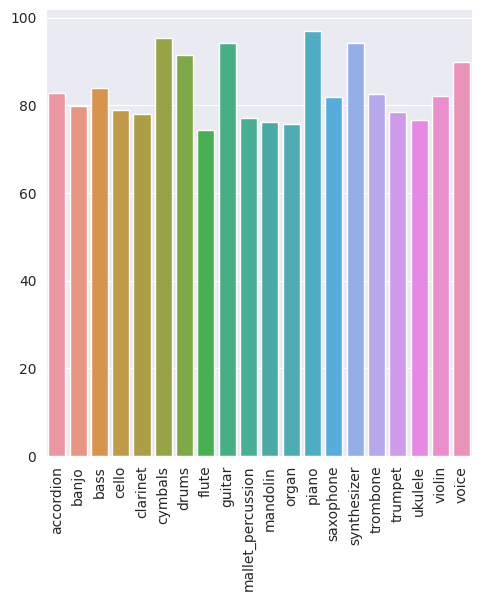

In [15]:
sns.catplot(
    pd.DataFrame(
        columns=idx_to_instrument.values(),
        data=[[calculate_accuracy(*x) for x in zip(resulting_pred, resulting_true)]]
    ),
    kind = 'bar'
)
plt.xticks(rotation=90)
;

In [16]:
test_dataloaders = {
    key: value[2] for key, value in dataloaders.items()
}

true_matrix, pred_matrix = evaluate_multilabel(DEVICE, models, matrix_shape=(shapes[2], len(instrument_to_idx)), dataloaders=test_dataloaders, instrument_to_idx=instrument_to_idx)

print('TEST')
m1 = squeeze_answer_matrix(true_matrix)
m2 = squeeze_answer_matrix(pred_matrix)
print(f'Exact Match Ratio {get_exact_match_ratio(m1, m2)}')
print(f'Accuracy {get_accuracy(m1, m2)}')

TEST
Exact Match Ratio 0.7050147492625368
Accuracy 0.7512509559707197
